In [1]:
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
from IPython import get_ipython
from numpy.linalg import svd
from util import nextplot, plot_xy
from sklearn.cluster import KMeans

# setup plotting
import psutil
inTerminal = not "IPKernelApp" in get_ipython().config
inJupyterNb = any(filter(lambda x: x.endswith("jupyter-notebook"), psutil.Process().parent().cmdline()))
inJupyterLab = any(filter(lambda x: x.endswith("jupyter-lab"), psutil.Process().parent().cmdline()))
if not inJupyterLab:
    from IPython import get_ipython
    get_ipython().run_line_magic("matplotlib", "" if inTerminal else "notebook" if inJupyterNb else "widget")

# 1 Probabilistic PCA

## 1a) Toy data

In [2]:
# You do not need to modify this method.
def ppca_gen(N=10000, D=2, L=2, sigma2=0.5, mu=None, lambda_=None, Q=None, seed=None):
    """Generate data from a given PPCA model.

    Unless specified otherwise, uses a fixed mean, fixed eigenvalues (variances along
    principal components), and a random orthogonal eigenvectors (principal components).

    """

    # determine model parameters (from arguments or default)
    rng = np.random.RandomState(seed)
    if mu is None:
        mu = np.arange(D) + 1.0
    if Q is None:
        Q = scipy.stats.ortho_group.rvs(D, random_state=rng)
    if lambda_ is None:
        lambda_ = np.arange(D, 0, -1) * 2

    # weight matrix is determined from first L eigenvectors and eigenvalues of
    # covariance matrix
    Q_L = Q[:, :L]
    lambda_L = lambda_[:L]
    W = Q_L * np.sqrt(lambda_L)  # scales columns

    # generate data
    Z = rng.standard_normal(size=(N, L))  # latent variables
    Eps = rng.standard_normal(size=(N, D)) * np.sqrt(sigma2)  # noise
    X = Z @ W.transpose() + mu + Eps  # data points

    # all done
    return dict(
        N=N, D=D, L=L, X=X, Z=Z, mu=mu, Q_L=Q_L, lambda_L=lambda_L, W=W, Eps=Eps
    )

In [3]:
# You do not need to modify this method.
def ppca_plot_2d(data, X="X", mu="mu", W="W", alpha=0.05, axis=None, **kwargs):
    """Plot 2D PPCA data along with its weight vectors."""
    if not axis:
        nextplot()
        axis = plt.gca()
    X = data[X] if isinstance(X, str) else X
    plot_xy(X[:, 0], X[:, 1], alpha=alpha, axis=axis, **kwargs)

    # additional plot elements: mean and components
    if mu is not None:
        mu = data[mu] if isinstance(mu, str) else mu
        if W is not None:
            W = data[W] if isinstance(W, str) else W
            head_width = np.linalg.norm(W[:, 0]) / 10.0
            for j in range(W.shape[1]):
                axis.arrow(
                    mu[0],
                    mu[1],
                    W[0, j],
                    W[1, j],
                    length_includes_head=True,
                    head_width=head_width,
                )

273244.3990646409


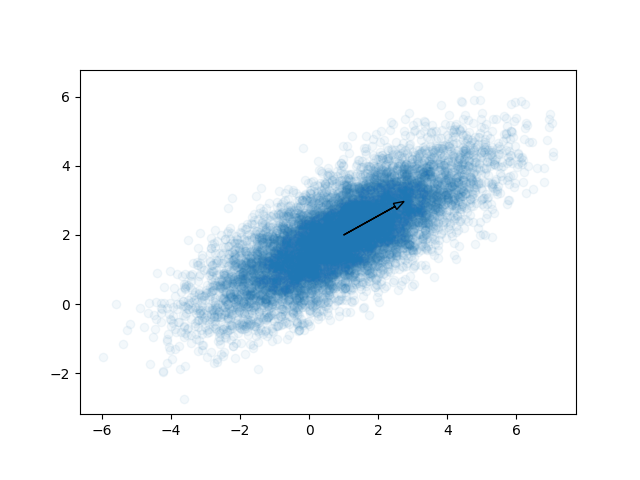

In [4]:
# Generate and plot a toy dataset
toy_ppca = ppca_gen(L=1, sigma2=0.5, seed=0)
ppca_plot_2d(toy_ppca)
print(np.sum(toy_ppca["X"] ** 3))  # must be 273244.3990646409

In [ ]:
# Impact of noise
# YOUR CODE HERE

## 1b) Maximum Likelihood Estimation

In [5]:
def ppca_mle(X, L):
    """Computes the ML estimates of PPCA model parameters.

    Returns a dictionary with keys `mu`, `W`, and `sigma2` and the corresponding ML
    estimates as values.

    """
    N, D = X.shape

    # Compute the ML estimates of the PPCA model parameters: mu_mle, sigma2_mle (based
    # on mu_mle), and W_mle (based on mu_mle and sigma2_mle). In your code, only use
    # standard matrix/vector operations and svd(...).
    # YOUR CODE HERE

    return dict(mu=mu_mle, W=W_mle, sigma2=sigma2_mle)

In [6]:
# Test your solution. This should produce:
# {'mu': array([0.96935329, 1.98309575]),
#  'W': array([[-1.72988776], [-0.95974566]]),
#  'sigma2': 0.4838656103694303}
ppca_mle(toy_ppca["X"], 1)

NameError: name 'mu_mle' is not defined

In [7]:
# Test your solution. This should produce:
# {'mu': array([0.96935329, 1.98309575]),
 # 'W': array([[-1.83371058,  0.33746522], [-1.0173468 , -0.60826214]]),
 # 'sigma2': 0.0}
ppca_mle(toy_ppca["X"], 2)

NameError: name 'mu_mle' is not defined

## 1c) Negative Log-Likelihood

In [ ]:
def ppca_nll(X, model):
    """Compute the negative log-likelihood for the given data.

    Model is a dictionary containing keys "mu", "sigma2" and "W" (as produced by
    `ppca_mle` above).

    """
    N, D = X.shape

    # YOUR CODE HERE

In [ ]:
# Test your solution. This should produce: 32154.198760474777
ppca_nll(toy_ppca["X"], ppca_mle(toy_ppca["X"], 1))

## 1d) Discover the Secret!

In [ ]:
# Load the secret data
X = np.loadtxt("data/secret_ppca.csv", delimiter=",")

In [ ]:
# Determine a suitable choice of L using a scree plot.
# Your code here

In [ ]:
# Determine a suitable choice of L using validation data.
split = len(X) * 3 // 4
X_train = X[:split,]
X_valid = X[split:,]

In [ ]:
# YOUR CODE HERE

# 2 Gaussian Mixture Models

## 2a) Toy data

In [8]:
# You do not need to modify this function.
def gmm_gen(N, mu, pi, Sigma=None, seed=None):
    """Generate data from a given GMM model.

    `N` is the number of data points to generate. `mu` and `Sigma` are lists with `K`
    elements holding the mean and covariance matrix of each mixture component. `pi` is a
    `K`-dimensional probability vector of component sizes.

    If `Sigma` is unspecified, a default (random) choice is taken.
    """
    K = len(pi)
    D = len(mu[0])
    rng = np.random.RandomState(seed)
    if Sigma is None:
        Sigma = [
            Q.transpose() @ np.diag([(k + 1) ** 2, k + 1]) @ Q
            for k, Q in enumerate([scipy.stats.ortho_group.rvs(2, random_state=rng) for k in range(K)])
        ]

    components = rng.choice(range(K), p=pi, size=N)
    X = np.zeros([N, D])
    for k in range(K):
        indexes = components == k
        N_k = np.sum(indexes.astype(np.int_))
        if N_k == 0:
            continue

        dist = scipy.stats.multivariate_normal(mean=mu[k], cov=Sigma[k], seed=rng)
        X[indexes, :] = dist.rvs(size=N_k)

    return dict(X=X, components=components, mu=mu, Sigma=Sigma, pi=pi)

This function `gmm_gen` generates data from a Gaussian Mixture Model (GMM). Here's a detailed explanation:

- **Parameters**:
  - `N`: The number of data points to generate.
  - `mu`: A list of `K` elements, each holding the mean of a mixture component.
  - `pi`: A `K`-dimensional probability vector representing the sizes of each component.
  - `Sigma`: (Optional) A list of `K` covariance matrices for each component. If not provided, default random covariance matrices are generated.
  - `seed`: (Optional) A seed for the random number generator to ensure reproducibility.

- **Steps**:
  1. Determine the number of components `K` from the length of `pi`.
  2. Determine the dimensionality `D` from the length of the first mean vector `mu[0]`.
  3. Initialize a random number generator `rng` with the provided `seed`.
  4. If `Sigma` is not provided, generate default random covariance matrices using orthogonal matrices and scaling factors.
  5. Randomly assign each data point to one of the `K` components based on the probabilities in `pi`.
  6. Initialize an array `X` to hold the generated data points.
  7. For each component `k`:
     - Identify the data points assigned to component `k`.
     - Generate `N_k` data points from a multivariate normal distribution with mean `mu[k]` and covariance `Sigma[k]`.
     - Assign these generated points to the corresponding positions in `X`.
  8. Return a dictionary containing the generated data `X`, the component assignments, and the parameters `mu`, `Sigma`, and `pi`.

This function is useful for simulating data from a GMM, which can be used for testing and validating clustering algorithms.

-4380876.753061278


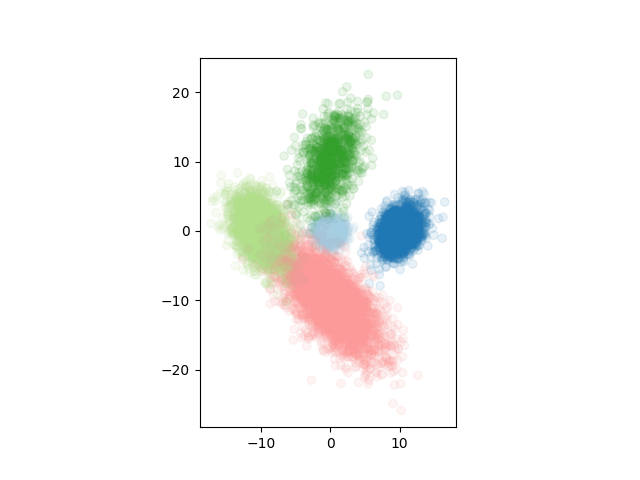

In [9]:
# Generate a toy dataset and plot it.
toy_gmm = gmm_gen(
    10000,
    [
        np.array([0, 0]),
        np.array([10, 0]),
        np.array([-10, 0]),
        np.array([0, 10]),
        np.array([0, -10]),
    ],
    np.array([0.1, 0.2, 0.25, 0.1, 0.35]),
    seed=4,
)

print(np.sum(toy_gmm["X"] ** 3))  # must be -4380876.753061278

plot_xy(toy_gmm["X"][:, 0], toy_gmm["X"][:, 1], toy_gmm["components"], alpha=0.1)

## 2b) K-Means

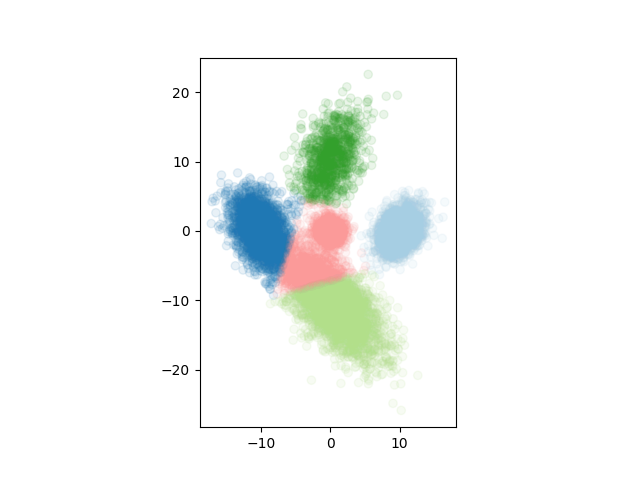

In [10]:
# Fit 5 clusters using k-means.
kmeans = KMeans(5).fit(toy_gmm["X"])
plot_xy(toy_gmm["X"][:, 0], toy_gmm["X"][:, 1], kmeans.labels_, alpha=0.1)

## 2c) Fit a GMM

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal

def gmm_e(X, model, return_F=False):
    """Perform the E step of EM for a GMM (MLE estimate).

    `model` is a dictionary holding model parameters (keys `mu`, `Sigma`, and `pi`
    defined as in `gmm_gen`).

    Returns a NxK matrix of cluster membership probabilities. If `return_F` is true,
    also returns an NxK matrix holding the density of each data point (row) for each
    component (column).
    """
    mu, Sigma, pi = model["mu"], model["Sigma"], model["pi"]
    N, D = X.shape
    K = len(pi)
    
    # YOUR CODE HERE
    # Initialize NxK matrices
    F = np.zeros((N, K))  # Density for each point and cluster
    W = np.zeros((N, K))  # Cluster membership probabilities
    
    # Compute the density for each cluster and data point
    for k in range(K):
        # Multivariate normal density
        dist = multivariate_normal(mean=mu[k], cov=Sigma[k])
        F[:, k] = dist.pdf(X)  # Likelihood for cluster k
    
    # Compute responsibilities (W) using mixing coefficients
    numerator = F * pi  # Element-wise multiplication with pi
    denominator = np.sum(numerator, axis=1, keepdims=True)  # Sum over clusters for normalization
    W = numerator / denominator  # Normalize to get probabilities
    
    # Return responsibilities (W) and optionally densities (F)
    if return_F:
        return W, F
    else:
        return W


In [12]:
# Test your solution. This should produce:
# (array([[9.99999999e-01, 8.65221693e-10, 1.59675131e-23, 1.14015011e-41, 2.78010004e-65],
        # [1.00000000e+00, 3.75078862e-12, 1.55035521e-23, 1.28102693e-34, 1.86750812e-46],
        # [9.99931809e-01, 6.81161224e-05, 7.23302032e-08, 2.17176125e-09, 1.62736835e-10]]),
 # array([[1.71811600e-08, 5.94620494e-18, 1.82893598e-31, 9.79455071e-50, 1.59217812e-73],
        # [1.44159783e-15, 2.16285148e-27, 1.48999246e-38, 9.23362817e-50, 8.97398547e-62],
        # [1.85095927e-09, 5.04355064e-14, 8.92595932e-17, 2.01005787e-18, 1.00413265e-19]]))
dummy_model = dict(
    mu=[np.array([k, k + 1]) for k in range(5)],
    Sigma=[np.array([[3, 1], [1, 2]]) / (k + 1) for k in range(5)],
    pi=np.array([0.1, 0.25, 0.15, 0.2, 0.3]),
)
gmm_e(toy_gmm["X"][:3,], dummy_model, return_F=True)

(array([[9.99999999e-01, 8.65221693e-10, 1.59675131e-23, 1.14015011e-41,
         2.78010004e-65],
        [1.00000000e+00, 3.75078862e-12, 1.55035521e-23, 1.28102693e-34,
         1.86750812e-46],
        [9.99931809e-01, 6.81161224e-05, 7.23302032e-08, 2.17176125e-09,
         1.62736835e-10]]),
 array([[1.71811600e-08, 5.94620494e-18, 1.82893598e-31, 9.79455071e-50,
         1.59217812e-73],
        [1.44159783e-15, 2.16285148e-27, 1.48999246e-38, 9.23362817e-50,
         8.97398547e-62],
        [1.85095927e-09, 5.04355064e-14, 8.92595932e-17, 2.01005787e-18,
         1.00413265e-19]]))

In [13]:
import numpy as np

def gmm_m(X, W):
    """Perform the M step of EM for a GMM (MLE estimate).

    `W` is the NxK cluster membership matrix computed in the E step. Returns a new model
    (dictionary with keys `mu`, `Sigma`, and `pi` defined as in `gmm_gen`).
    """
    N, D = X.shape
    K = W.shape[1]
    
    # YOUR CODE HERE
    # Initialize parameters
    mu = np.zeros((K, D))       # Cluster means
    Sigma = []                  # Covariance matrices (list of K matrices)
    pi = np.zeros(K)            # Mixing coefficients

    # Compute mixing coefficients
    Nk = np.sum(W, axis=0)  # Sum of responsibilities for each cluster
    pi = Nk / N             # Normalize to get mixing coefficients

    # Compute means
    mu = (W.T @ X) / Nk[:, np.newaxis]  # Weighted mean for each cluster

    # Compute covariance matrices
    for k in range(K):
        X_centered = X - mu[k]  # Center data points relative to mean
        weighted_cov = (W[:, k][:, np.newaxis] * X_centered).T @ X_centered
        Sigma_k = weighted_cov / Nk[k]  # Normalize by cluster weight
        Sigma.append(Sigma_k)

    # Convert Sigma to a numpy array of K covariance matrices
    Sigma = np.array(Sigma)

    # Return updated model
    return dict(mu=mu, Sigma=Sigma, pi=pi)


In [14]:
# Test your solution. This should produce:
# {'mu': [array([ 6.70641574, -0.47971125]),
#   array([8.2353509 , 2.52134815]),
#   array([-3.0476848 , -1.70722161])],
#  'Sigma': [array([[88.09488652, 11.08635139],
#          [11.08635139,  1.39516823]]),
#   array([[45.82761873, 11.38773232],
#          [11.38773232,  6.87352224]]),
#   array([[98.6662729 , 12.41671355],
#          [12.41671355,  1.56258842]])],
#  'pi': array([0.13333333, 0.53333333, 0.33333333])}
gmm_m(toy_gmm["X"][:3,], np.array([[0.1, 0.2, 0.7], [0.3, 0.4, 0.3], [0.0, 1.0, 0.0]]))

{'mu': array([[ 6.70641574, -0.47971125],
        [ 8.2353509 ,  2.52134815],
        [-3.0476848 , -1.70722161]]),
 'Sigma': array([[[88.09488652, 11.08635139],
         [11.08635139,  1.39516823]],
 
        [[45.82761873, 11.38773232],
         [11.38773232,  6.87352224]],
 
        [[98.6662729 , 12.41671355],
         [12.41671355,  1.56258842]]]),
 'pi': array([0.13333333, 0.53333333, 0.33333333])}

In [15]:
# you do not need to modify this method
def gmm_fit(X, K, max_iter=100, mu0=None, Sigma0=None, pi0=None, gmm_m=gmm_m):
    """Fit a GMM model using EM.

    `K` refers to the number of mixture components to fit. `mu0`, `Sigma0`, and `pi0`
    are initial parameters (automatically set when unspecified).

    """
    N, D = X.shape

    if mu0 is None:
        mu0 = [np.random.randn(D) for k in range(K)]
    if Sigma0 is None:
        Sigma0 = [np.eye(D) * 10 for k in range(K)]
    if pi0 is None:
        pi0 = np.ones(K) / K

    model = dict(mu=mu0, Sigma=Sigma0, pi=pi0)
    for it in range(max_iter):
        W = gmm_e(X, model)
        model = gmm_m(X, W)

    return model

## 2d+2e) Experiment with GMMs for the toy data

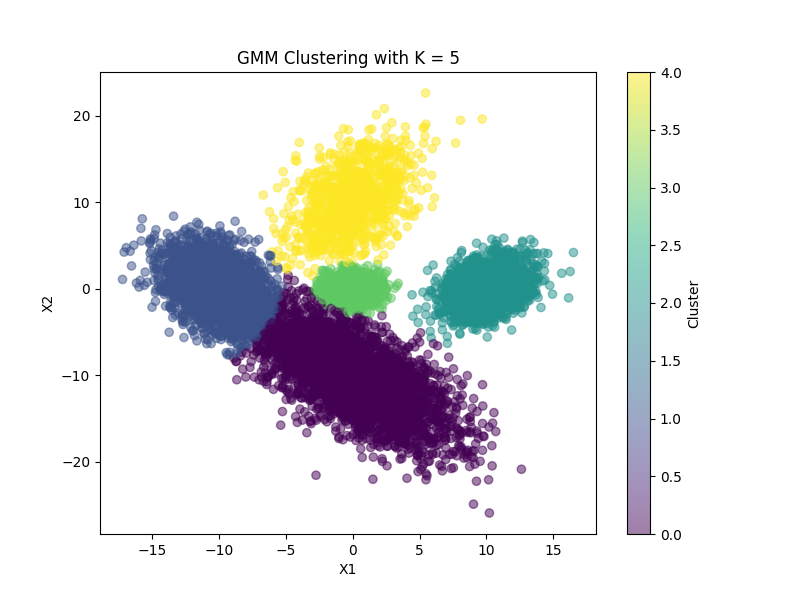

In [16]:
# Fit on toy data and color each point by most likely component. Also try fitting with 4
# or 6 components.
toy_gmm_fit = gmm_fit(toy_gmm["X"], 5)
# YOUR CODE HERE

# Assign each data point to the most likely cluster
W_5 = gmm_e(toy_gmm["X"], toy_gmm_fit)
most_likely_cluster_5 = np.argmax(W_5, axis=1)  # Assign each point to its most probable cluster

# Plot the clustering result for K = 5
plt.figure(figsize=(8, 6))
plt.scatter(toy_gmm["X"][:, 0], toy_gmm["X"][:, 1], c=most_likely_cluster_5, cmap="viridis", alpha=0.5)
plt.title("GMM Clustering with K = 5")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Cluster")
plt.show()

## 2f) Discover the Secret (optional)

In [ ]:
# Load the secret data.
X = np.loadtxt("data/secret_gmm.csv", delimiter=",")

In [ ]:
# How many components are hidden in this data?